In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import zipfile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
start_time = time.time()


Using device: cuda


In [ ]:
from google.colab import files

print("Please upload your ZIP file containing 152 healthy images:")
uploaded = files.upload()

for fname in uploaded.keys():
    zip_path = fname

extracted_dir = 'healthy_images'
os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("✅ Extracted to:", extracted_dir)


Please upload your ZIP file containing 152 healthy images:


Saving healthy.zip to healthy.zip
✅ Extracted to: healthy_images


In [ ]:
def get_all_image_paths(root_folder):
    valid_exts = ['.jpg', '.jpeg', '.png']
    image_paths = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_exts:
                image_paths.append(os.path.join(root, file))
    return image_paths

all_image_paths = get_all_image_paths(extracted_dir)
if len(all_image_paths) == 0:
    raise ValueError("❌ No images found!")

print(f"✅ Found {len(all_image_paths)} images.")


✅ Found 152 images.


In [ ]:
# STEP 4: Dataset and Transforms
class HealthyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = HealthyDataset(all_image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=min(32, len(dataset)), shuffle=True)



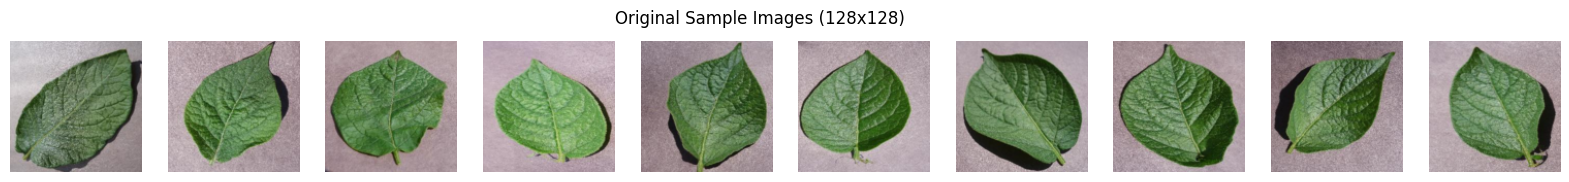

In [ ]:
# STEP 5: Show Images Helper
def show_images(images, title):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        img = images[i].detach().cpu()
        if img.shape[0] == 1:  # Grayscale
            img = img.squeeze(0)
            axes[i].imshow(img, cmap='gray')
        else:  # RGB
            img = img.permute(1, 2, 0)
            axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

sample_batch = next(iter(dataloader))
show_images(sample_batch, "Original Sample Images (128x128)")


In [ ]:
# STEP 6: Enhanced VAE with intermediate outputs
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),  # 16 -> 8
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 512 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)  # 8 -> 16
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # 16 -> 32
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)   # 32 -> 64
        self.deconv4 = nn.ConvTranspose2d(64, 3, 4, 2, 1)     # 64 -> 128

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        x = self.decoder_input(z).view(-1, 512, 8, 8)

        x1 = self.deconv1(x)
        x2 = self.deconv2(x1)
        x3 = self.deconv3(x2)
        x4 = torch.sigmoid(self.deconv4(x3))

        # Reduce channels for visualization
        vis1 = x1.mean(dim=1, keepdim=True)
        vis2 = x2.mean(dim=1, keepdim=True)
        vis3 = x3.mean(dim=1, keepdim=True)

        return x4, mu, logvar, [vis1, vis2, vis3, x4]



In [ ]:
# STEP 7: Train the VAE
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

epochs = 30
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, _ = vae(batch)
        loss = loss_function(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataset):.2f}")



Epoch 1/30, Loss: 1500.33
Epoch 2/30, Loss: 1298.86
Epoch 3/30, Loss: 1178.02
Epoch 4/30, Loss: 1069.21
Epoch 5/30, Loss: 1028.64
Epoch 6/30, Loss: 1002.05
Epoch 7/30, Loss: 997.10
Epoch 8/30, Loss: 991.58
Epoch 9/30, Loss: 976.66
Epoch 10/30, Loss: 980.74
Epoch 11/30, Loss: 975.40
Epoch 12/30, Loss: 961.10
Epoch 13/30, Loss: 961.55
Epoch 14/30, Loss: 959.12
Epoch 15/30, Loss: 954.26
Epoch 16/30, Loss: 929.90
Epoch 17/30, Loss: 899.99
Epoch 18/30, Loss: 824.65
Epoch 19/30, Loss: 780.37
Epoch 20/30, Loss: 753.44
Epoch 21/30, Loss: 721.65
Epoch 22/30, Loss: 709.63
Epoch 23/30, Loss: 689.43
Epoch 24/30, Loss: 665.26
Epoch 25/30, Loss: 662.61
Epoch 26/30, Loss: 649.83
Epoch 27/30, Loss: 636.51
Epoch 28/30, Loss: 635.21
Epoch 29/30, Loss: 626.03
Epoch 30/30, Loss: 629.43


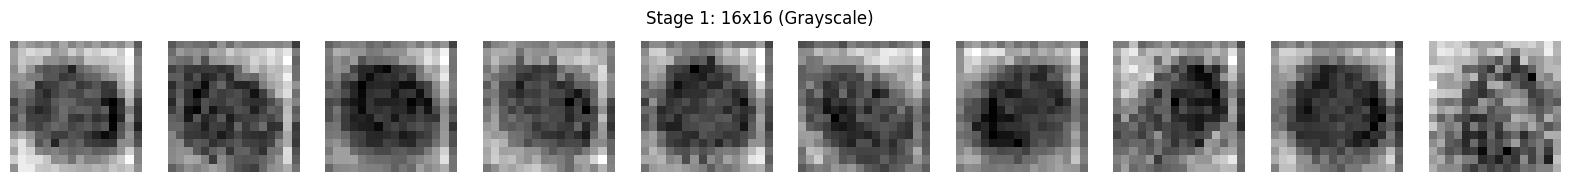

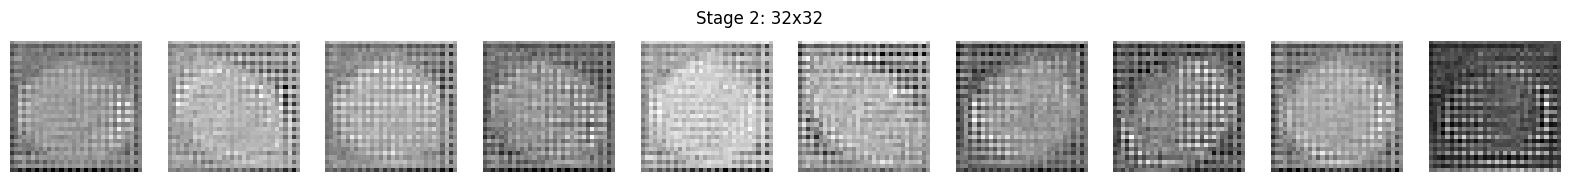

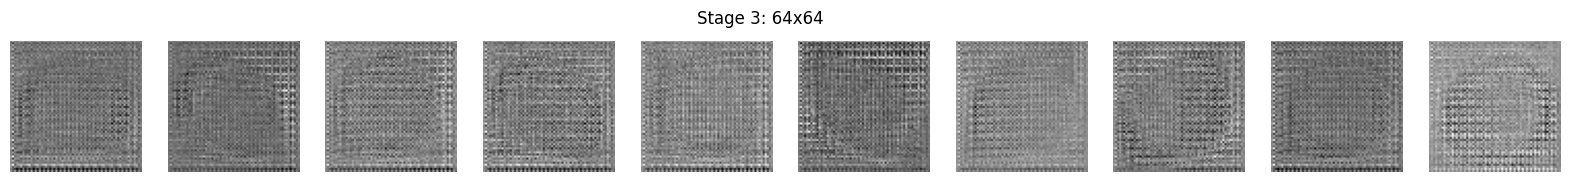

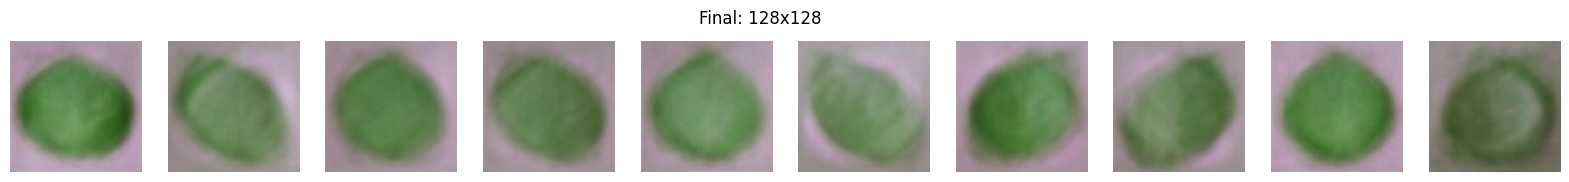

In [ ]:
# STEP 8: Visualize Intermediate Decoder Outputs
vae.eval()
test_batch = next(iter(dataloader)).to(device)
with torch.no_grad():
    recon_final, _, _, stages = vae(test_batch)

titles = ["Stage 1: 16x16 (Grayscale)", "Stage 2: 32x32", "Stage 3: 64x64", "Final: 128x128"]
for i in range(4):
    show_images(stages[i][:10], titles[i])


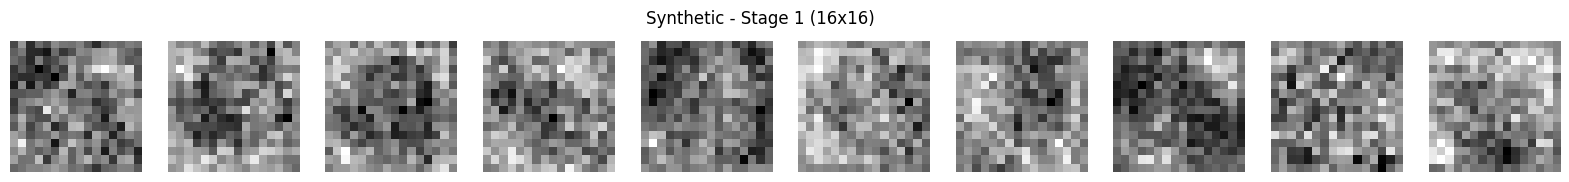

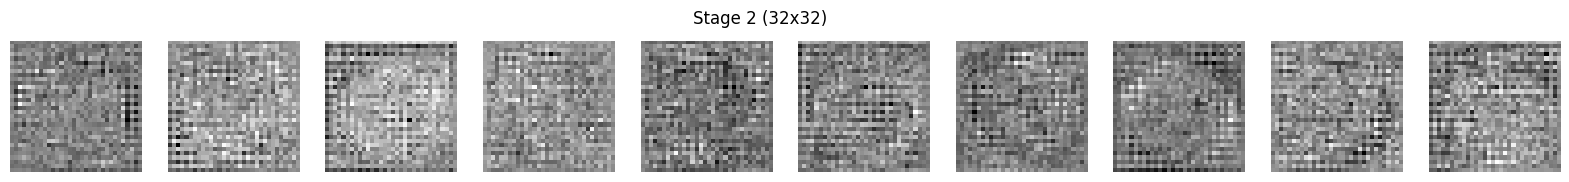

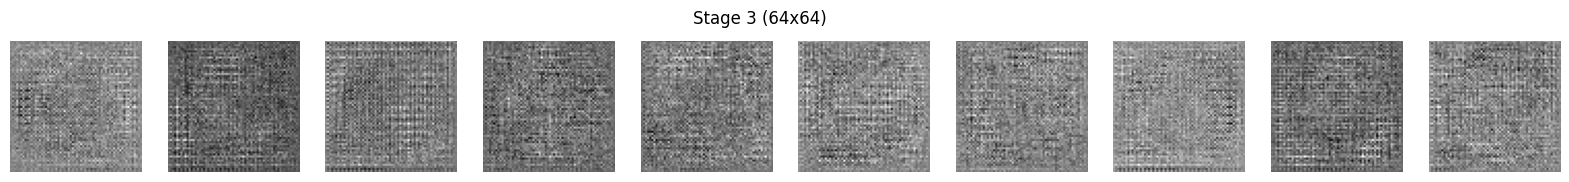

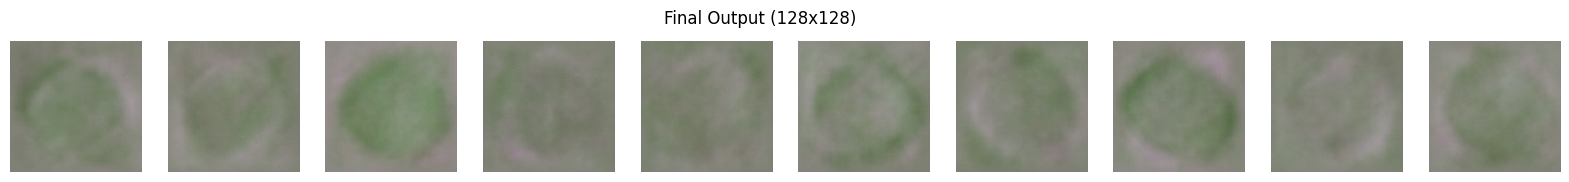

In [ ]:
# STEP 9: Generate and Show 10 Synthetic Images at All Stages
def generate_synthetic_images(model, num=50):
    model.eval()
    z = torch.randn(num, model.latent_dim).to(device)
    with torch.no_grad():
        x = model.decoder_input(z).view(-1, 512, 8, 8)
        x1 = model.deconv1(x).mean(dim=1, keepdim=True)
        x2 = model.deconv2(model.deconv1(x)).mean(dim=1, keepdim=True)
        x3 = model.deconv3(model.deconv2(model.deconv1(x))).mean(dim=1, keepdim=True)
        x4 = torch.sigmoid(model.deconv4(model.deconv3(model.deconv2(model.deconv1(x)))))
    return [x1, x2, x3, x4]

synthetic_stages = generate_synthetic_images(vae, 50)
titles = ["Synthetic - Stage 1 (16x16)", "Stage 2 (32x32)", "Stage 3 (64x64)", "Final Output (128x128)"]
for i in range(4):
    show_images(synthetic_stages[i][:10], titles[i])
